# Wildlife wasp photos semantic segmentation

# Data Description

The dataset was taken from: https://www.kaggle.com/datasets/metavision/accurate-wasp-shapessegmentation

The dataset contains 2482 photos of wasps in wildlife with accurate masks for semantic segmentation. Wasps are relatively small objects in comparison to background, so there is a significant class imbalance. It is also necessary to take into consideration the fact that wasps are objects with complex contours. The shapes of the masks are quite complicated and heterogeneous, which makes it quite difficult to perform an accurate semantic segmentation to get masks which match the shapes of wasps really good instead of simple spots.

In this project I will try to build a computer vision model that can separate from the background not only the main silhouettes of wasps, but also details: wings, antennae, paws.

# Importing necessary libraries & loading data

In [1]:
! pip install -U segmentation-models-pytorch

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 376 kB 35.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=86db69592850ae985982c370a776e712d174a29a74313d161cbc897fa5afee9f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3c2ed5a4004db7b380b1d8d986af71bf688de5f006f6766b52a7fd8842e31458
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.2 MB/s 
     |████████████████████████████████| 948 kB 36.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=d59852732adc274873d4cdf51deaef637c1df8863319ad2ec46624d9ac2d2981
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import os
from tqdm.autonotebook import tqdm, trange
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import copy
import time
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import albumentations.augmentations.functional as F

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [4]:
!pip install kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d metavision/accurate-wasp-shapessegmentation

 96% 249M/259M [00:02<00:00, 107MB/s]
100% 259M/259M [00:02<00:00, 121MB/s]


In [9]:
!unzip accurate-wasp-shapessegmentation.zip

Archive:  accurate-wasp-shapessegmentation.zip
  inflating: 29-wasp-01/720p/image00000001.jpg  
  inflating: 29-wasp-01/720p/image00000002.jpg  
  inflating: 29-wasp-01/720p/image00000003.jpg  
  inflating: 29-wasp-01/720p/image00000004.jpg  
  inflating: 29-wasp-01/720p/image00000005.jpg  
  inflating: 29-wasp-01/720p/image00000006.jpg  
  inflating: 29-wasp-01/720p/image00000007.jpg  
  inflating: 29-wasp-01/720p/image00000008.jpg  
  inflating: 29-wasp-01/720p/image00000009.jpg  
  inflating: 29-wasp-01/720p/image00000010.jpg  
  inflating: 29-wasp-01/720p/image00000011.jpg  
  inflating: 29-wasp-01/720p/image00000012.jpg  
  inflating: 29-wasp-01/720p/image00000013.jpg  
  inflating: 29-wasp-01/720p/image00000014.jpg  
  inflating: 29-wasp-01/720p/image00000015.jpg  
  inflating: 29-wasp-01/720p/image00000016.jpg  
  inflating: 29-wasp-01/720p/image00000017.jpg  
  inflating: 29-wasp-01/720p/image00000018.jpg  
  inflating: 29-wasp-01/720p/image00000019.jpg  
  inflating: 29-wasp-0

# Data Preprocessing

In [10]:
# splitting the dataset into train, validation and test parts
data_dir = './29-wasp-01'
images_dir = './29-wasp-01/720p'
masks_dir = './29-wasp-01/mask'
images_filenames = list(sorted(os.listdir(images_dir)))
print('Total number of images in the dataset: {}'.format(len(images_filenames)))

random.seed(42)
random.shuffle(images_filenames)

test_size = 10
train_val_size = len(images_filenames) - test_size
indexes = list(range(train_val_size))
val_part = 0.2
split = int(np.floor(train_val_size * val_part))

train_images_filenames = images_filenames[split:train_val_size]
val_images_filenames = images_filenames[:split]
test_images_filenames = images_filenames[-test_size:]

print('Splitted the dataset into 3 parts: {} train images, {} validation images, {} test images'.format(
    len(train_images_filenames), len(val_images_filenames), len(test_images_filenames)))

Total number of images in the dataset: 2482
Splitted the dataset into 3 parts: 1978 train images, 494 validation images, 10 test images


In [11]:
# function for mask encoding
def preprocess_mask(rgb_mask):
    if isinstance(rgb_mask, np.ndarray):
        rgb_mask = torch.from_numpy(rgb_mask)
    rgb_mask = rgb_mask[:, :, 2]
    background_mask = rgb_mask.clone()
    wasp_mask = rgb_mask.clone()
    wasp_mask[wasp_mask != 0.0] = 1.0
    background_mask[background_mask == 0.0] = 1.0
    background_mask[background_mask != 1.0] = 0.0
    output_mask = torch.stack((background_mask, wasp_mask), dim=2)
    output_mask = torch.permute(output_mask, (2, 0, 1))
    return output_mask

In [12]:
# function for visualization of encoded ground truth masks and predictions
def show_images(images_filenames, images_dir, masks_dir, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 70))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_dir, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_dir, 'mask'+image_filename[5:-4]+'.png'), cv2.IMREAD_UNCHANGED)
        mask = preprocess_mask(mask)
        axes[i, 0].imshow(image)
        axes[i, 1].imshow(mask[1, :, :])

        axes[i, 0].set_title('Image')
        axes[i, 1].set_title('Ground truth mask')

        axes[i, 0].set_axis_off()
        axes[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            axes[i, 2].imshow(predicted_mask, interpolation='bilinear')
            axes[i, 2].set_title('Predicted mask')
            axes[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

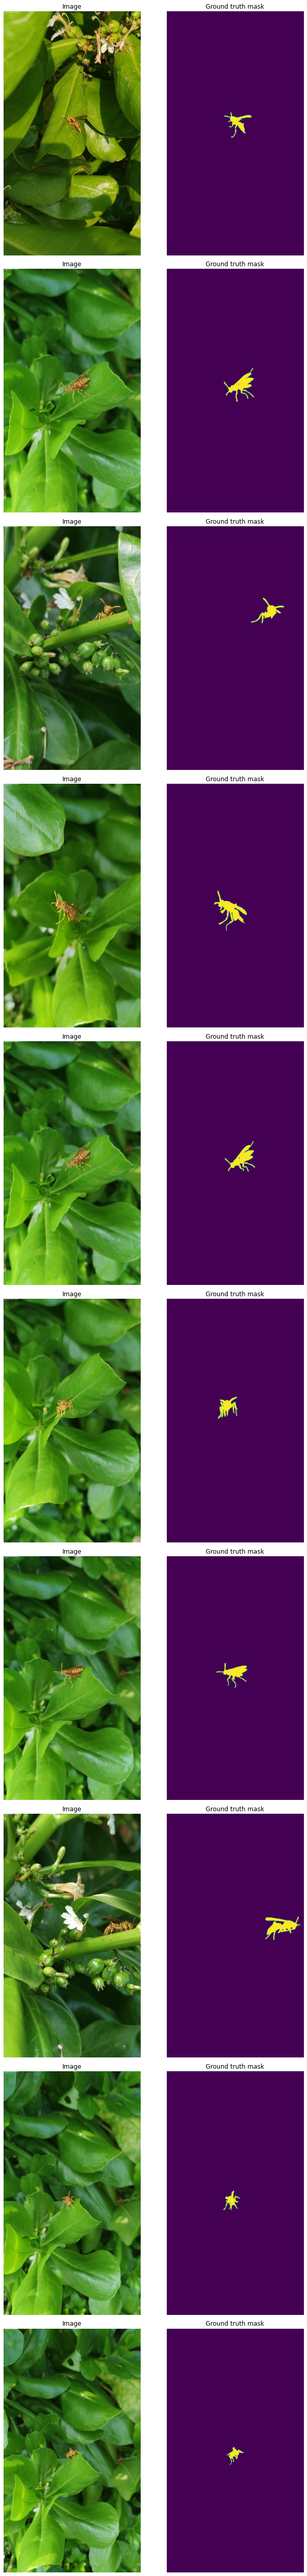

In [13]:
show_images(test_images_filenames, images_dir, masks_dir)

In [14]:
class Wasps_Dataset(Dataset):
    def __init__(self, images_filenames, images_dir, masks_dir, transform=None):
        self.images_filenames = images_filenames
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image = cv2.imread(os.path.join(self.images_dir, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_dir, 'mask'+image_filename[5:-4]+'.png'), cv2.IMREAD_UNCHANGED)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        mask = preprocess_mask(mask)
        return image, mask

So the pipeline will be the following: resize all images and masks to a 256x256 size for model training --> predict masks on unseen data with 256x256 size --> resize predicted masks to the size of original images.

In [15]:
# data augmentation
train_transform = A.Compose(
    [A.Resize(256, 256),
     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
     A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.4, p=0.5),
     A.HorizontalFlip(p=0.5),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()])
val_transform = A.Compose(
    [A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()])

In [16]:
train_dataset = Wasps_Dataset(train_images_filenames, images_dir, masks_dir, train_transform)
val_dataset = Wasps_Dataset(val_images_filenames, images_dir, masks_dir, val_transform)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
data_loaders = {'train': train_loader, 'val': val_loader}

In [18]:
image_batch, segmentation_batch = next(iter(train_loader))
image_batch.shape, segmentation_batch.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 2, 256, 256]))

In [19]:
# function for visualization of augmented images and their masks
def augmentation_viz(dataset, index=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([i for i in dataset.transform if not isinstance(i, (A.Normalize, ToTensorV2))])
    fig, axes = plt.subplots(nrows=samples, ncols=2, figsize=(10, 30))
    for i in range(samples):
        image, mask = dataset[index]
        axes[i, 0].imshow(image)
        axes[i, 1].imshow(mask[1, :, :])
        axes[i, 0].set_title('Augmented_image')
        axes[i, 1].set_title('Augmented_mask')
        axes[i, 0].set_axis_off()
        axes[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

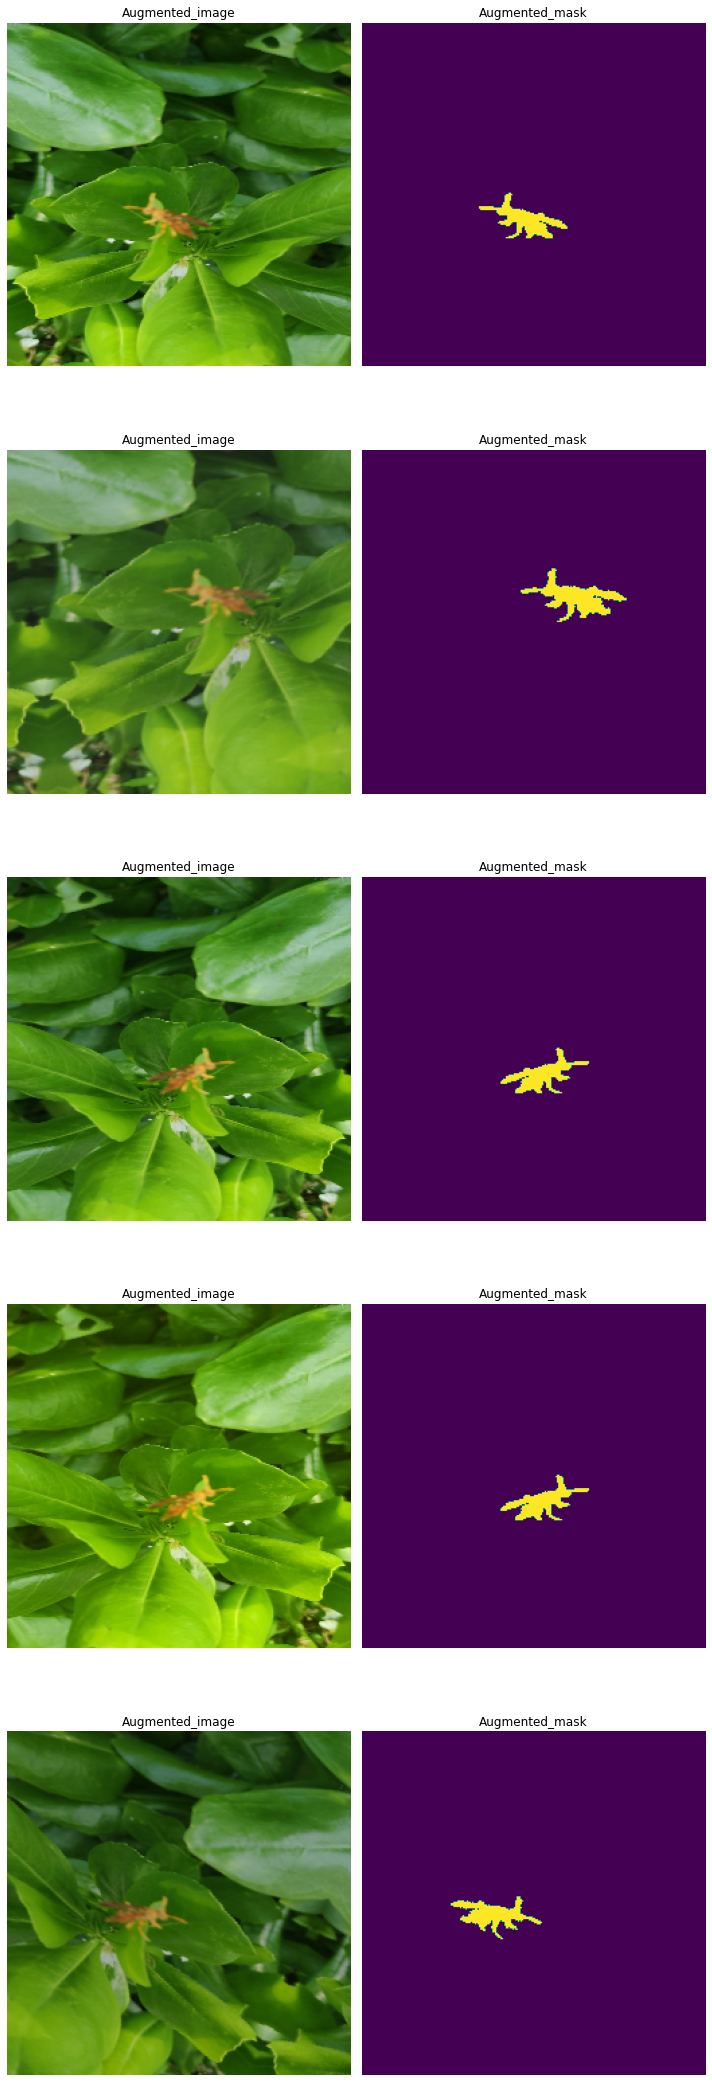

In [20]:
augmentation_viz(train_dataset)

# Model training

In [21]:
model = smp.UnetPlusPlus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    classes=2,
    activation='sigmoid')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [22]:
loss = smp.losses.TverskyLoss(mode='binary', alpha=0.75, beta=0.25)
loss.__name__ = 'tversky_loss'
optimizer = optim.Adam(model.parameters(), lr=0.001)
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
train_epoch = smp.utils.train.TrainEpoch(model,
                                         loss=loss,
                                         metrics=metrics,
                                         optimizer=optimizer,
                                         device=device,
                                         verbose=True)

val_epoch = smp.utils.train.ValidEpoch(model,
                                       loss=loss,
                                       metrics=metrics,
                                       device=device,
                                       verbose=True)

In [24]:
max_score = 0
n_epochs = 20

for i in range(0, n_epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = val_epoch.run(val_loader) 
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth') 
    if i == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decreased learning rate to 1e-5')
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decreased learning rate to 1e-7')


Epoch: 0
valid: 100%|██████████| 31/31 [00:44<00:00,  1.45s/it, tversky_loss - 0.3785, iou_score - 0.9957]

Epoch: 1
valid: 100%|██████████| 31/31 [00:43<00:00,  1.41s/it, tversky_loss - 0.3777, iou_score - 0.9969]

Epoch: 2
valid: 100%|██████████| 31/31 [00:43<00:00,  1.39s/it, tversky_loss - 0.3774, iou_score - 0.9974]

Epoch: 3
valid: 100%|██████████| 31/31 [00:43<00:00,  1.40s/it, tversky_loss - 0.3773, iou_score - 0.9977]

Epoch: 4
valid: 100%|██████████| 31/31 [00:43<00:00,  1.40s/it, tversky_loss - 0.3772, iou_score - 0.9978]

Epoch: 5
valid: 100%|██████████| 31/31 [00:43<00:00,  1.41s/it, tversky_loss - 0.3772, iou_score - 0.998]

Epoch: 6
valid: 100%|██████████| 31/31 [00:44<00:00,  1.42s/it, tversky_loss - 0.3772, iou_score - 0.9979]

Epoch: 7
valid: 100%|██████████| 31/31 [00:44<00:00,  1.42s/it, tversky_loss - 0.3772, iou_score - 0.9981]

Epoch: 8
valid: 100%|██████████| 31/31 [00:44<00:00,  1.43s/it, tversky_loss - 0.3771, iou_score - 0.9983]

Epoch: 9
valid: 100%|███████

# Inference

In [25]:
best_model = torch.load('./best_model.pth')

In [26]:
class Wasps_Inference_Dataset(Dataset):
    def __init__(self, images_filenames, images_dir, transform=None):
        self.images_filenames = images_filenames
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, index):
        image_filename = self.images_filenames[index]
        image = cv2.imread(os.path.join(self.images_dir, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']  
        return image, original_size

In [27]:
# preprocessing transformations for test images
test_transform = A.Compose([A.Resize(256, 256),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()])
test_dataset = Wasps_Inference_Dataset(test_images_filenames, images_dir, transform=test_transform)

In [28]:
def predict(model, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, original_size in test_loader:
            original_heights, original_widths = original_size
            images = images.to(device)
            outputs = model(images)
            predicted_masks = torch.argmax(outputs, dim=1)
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(predicted_masks,
                                                                         original_heights.numpy(),
                                                                         original_widths.numpy()):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [29]:
predictions = predict(best_model, test_dataset)

In [30]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = F.resize(predicted_256x256_mask,
                               height=original_height,
                               width=original_width,
                               interpolation=cv2.INTER_NEAREST)
    predicted_masks.append(full_sized_mask)

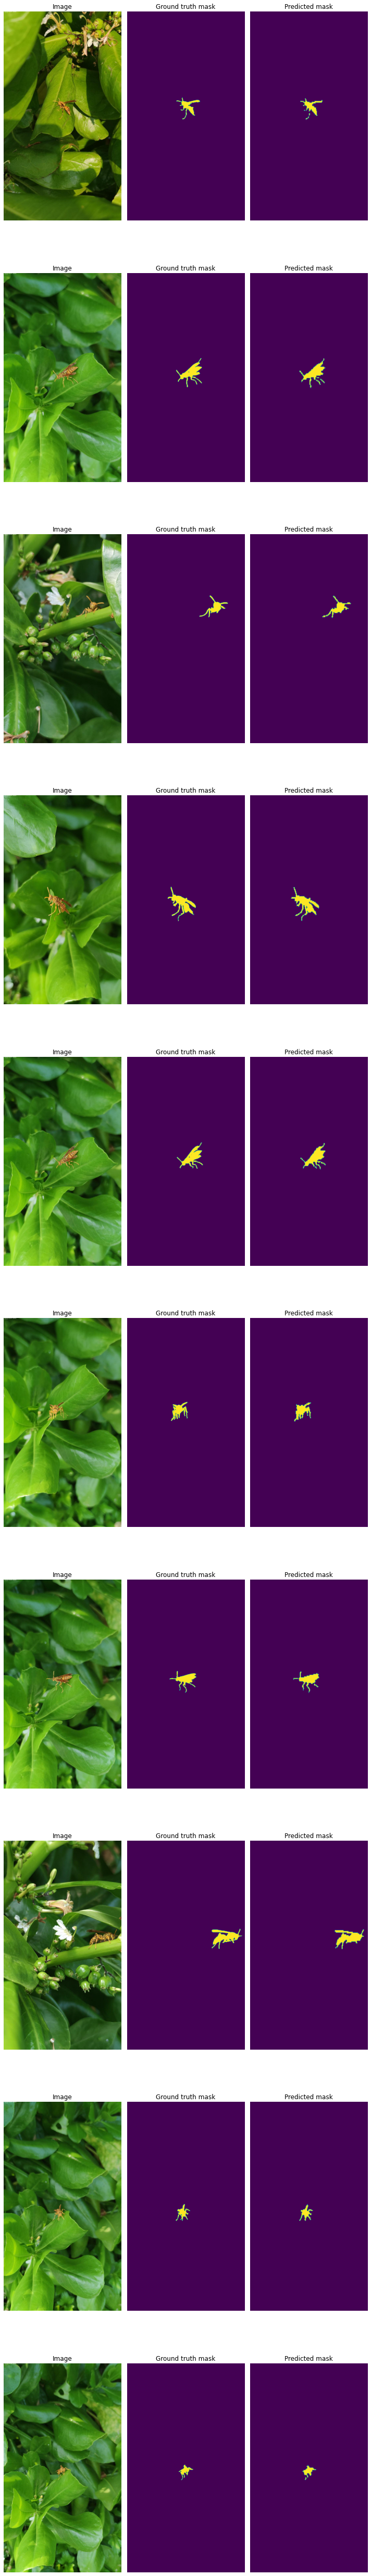

In [31]:
# visualization of results
show_images(test_images_filenames, images_dir, masks_dir, predicted_masks=predicted_masks)